In [2]:
from urllib.request import urlopen
from rdflib import Graph, plugin
import pandas as pd
import matplotlib.pyplot as plt

from ipywidgets import widgets,interact
from IPython.display import display, HTML

In [3]:
json_data = urlopen("http://sfsheath.github.io/roman-amphitheaters/roman-amphitheaters.geojson")
g = Graph().parse(data=json_data.read(), format='json-ld')

In [49]:
low_widget = widgets.IntSlider(value=7500,min=2000, max=55000, step = 1000)
high_widget = widgets.IntSlider(value=55000,min=2000, max=55000, step = 1000)
display(HTML("Capacity Greater Than:"),low_widget, HTML("Capacity Less Than:"), high_widget)

IntSlider(value=7500, max=55000, min=2000, step=1000)

IntSlider(value=55000, max=55000, min=2000, step=1000)

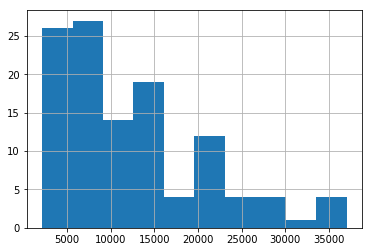

In [48]:
lower_range = low_widget.value
upper_range = high_widget.value

results = g.query("""
PREFIX ramphs: <http://purl.org/roman-amphitheaters/resource/>
PREFIX gj: <https://purl.org/geojson/vocab#>
PREFIX ramphs-p: <http://purl.org/roman-amphitheaters/properties#>
PREFIX dcterms: <http://purl.org/dc/terms/>
SELECT ?title ?capacity WHERE {

?s gj:properties/ramphs-p:capacity/ramphs-p:quantity ?capacity .

FILTER ((?capacity > %s) )
FILTER (?capacity < %s)
}""" % (lower_range, upper_range ) )

caps = []
for row in results:
    caps.append(float(row.capacity))
ramphs_pd = pd.Series({'capacity':caps})
ramphs_pd.hist()